In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors


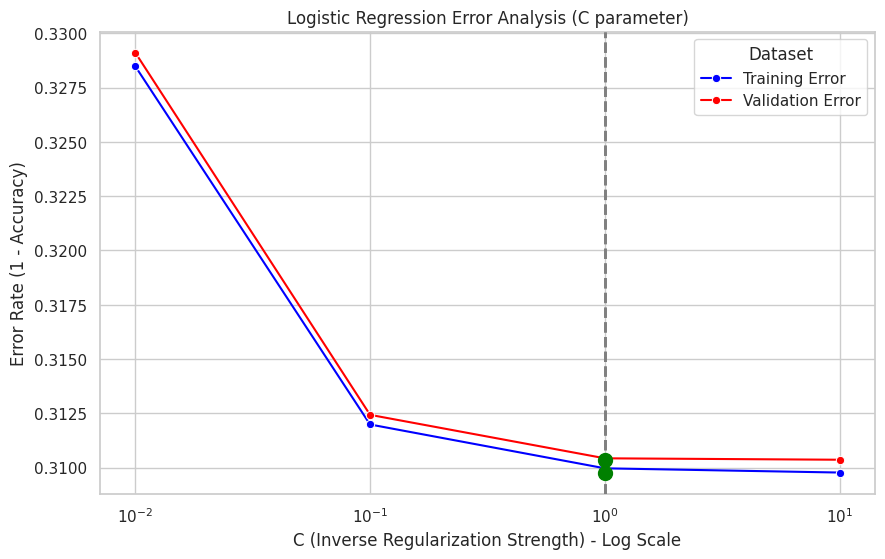

In [8]:
with open('../../models/tuning/logistic_regression_tuning.json', 'r') as f:
    data = json.load(f)

parsed_data = []
for entry in data['all_combinations']:
    parsed_data.append({
        'C': entry['params']['C'],
        'Training Error': 1 - entry['mean_train_score'],
        'Validation Error': 1 - entry['mean_test_score']
    })

df = pd.DataFrame(parsed_data)
df_melted = df.melt(id_vars='C', var_name='Dataset', value_name='Error Rate')

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

sns.lineplot(
    data=df_melted,
    x='C',
    y='Error Rate',
    hue='Dataset',
    marker='o',
    palette=['blue', 'red']
)

for dataset in ['Training Error', 'Validation Error']:
    mask = (df['C'] == 10.0)
    if mask.any():
        y_val = df.loc[mask, dataset].values[0]
        plt.scatter(1, y_val, color='green', s=100, zorder=10)
        plt.axvline(x=1, color='grey', linestyle='--', linewidth=2, zorder=5)

plt.xscale('log')
plt.title('Logistic Regression Error Analysis (C parameter)')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.xlabel('C (Inverse Regularization Strength) - Log Scale')

plt.show()

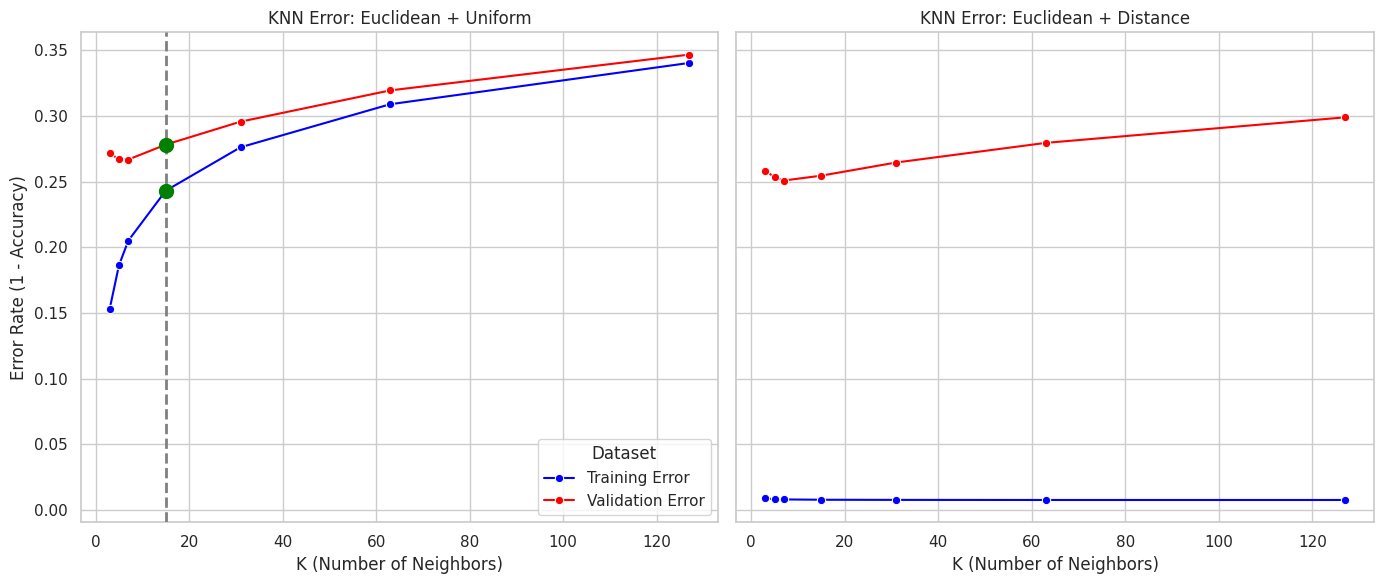

In [9]:

with open('../../models/tuning/knn_tuning.json', 'r') as f:
    data = json.load(f)

parsed_uniform = []
parsed_distance = []
for entry in data['all_combinations']:
    params = entry['params']
    if params['metric'] == 'euclidean' and params['weights'] == 'uniform':
        parsed_uniform.append({
            'K': params['n_neighbors'],
            'Training Error': 1 - entry['mean_train_score'],
            'Validation Error': 1 - entry['mean_test_score']
        })
    if params['metric'] == 'euclidean' and params['weights'] == 'distance':
        parsed_distance.append({
            'K': params['n_neighbors'],
            'Training Error': 1 - entry['mean_train_score'],
            'Validation Error': 1 - entry['mean_test_score']
        })

df_uniform = pd.DataFrame(parsed_uniform)
df_distance = pd.DataFrame(parsed_distance)
df_uniform_melted = df_uniform.melt(id_vars='K', var_name='Dataset', value_name='Error Rate')
df_distance_melted = df_distance.melt(id_vars='K', var_name='Dataset', value_name='Error Rate')

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.lineplot(
    data=df_uniform_melted, 
    x='K', 
    y='Error Rate', 
    hue='Dataset', 
    marker='o',
    palette=['blue', 'red'],
    ax=axes[0]
)
axes[0].set_title('KNN Error: Euclidean + Uniform')
axes[0].set_ylabel('Error Rate (1 - Accuracy)')
axes[0].set_xlabel('K (Number of Neighbors)')

uniform_k15 = df_uniform[df_uniform['K'] == 15]
if not uniform_k15.empty:
    y_val = uniform_k15['Validation Error'].values[0]
    axes[0].scatter(15, y_val, color='green', s=100, zorder=10)
    y_train = uniform_k15['Training Error'].values[0]
    axes[0].scatter(15, y_train, color='green', s=100, zorder=10)
    axes[0].axvline(x=15, color='grey', linestyle='--', linewidth=2, zorder=5)

sns.lineplot(
    data=df_distance_melted, 
    x='K', 
    y='Error Rate', 
    hue='Dataset', 
    marker='o',
    palette=['blue', 'red'],
    ax=axes[1]
)
axes[1].set_title('KNN Error: Euclidean + Distance')
axes[1].set_ylabel('')
axes[1].set_xlabel('K (Number of Neighbors)')

axes[1].legend_.remove()

plt.tight_layout()
plt.show()


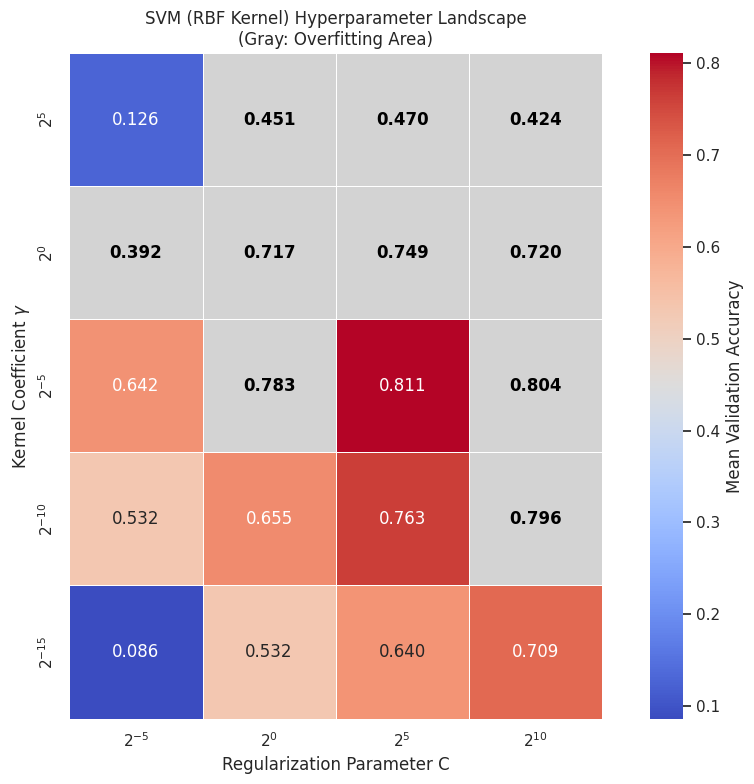

In [10]:
with open('../../models/tuning/svm_tuning.json', 'r') as f:
    data = json.load(f)

parsed_data = []
for entry in data['all_combinations']:
    p = entry['params']
    parsed_data.append({
        'C': p['C'],
        'gamma': p['gamma'],
        'Score': entry['mean_test_score'],
        'Overfitting': entry.get('is_overfitting', False)
    })

df = pd.DataFrame(parsed_data)
df['log_C'] = df['C'].apply(lambda x: f"$2^{{{int(np.round(np.log2(x)))}}}$")
df['log_gamma'] = df['gamma'].apply(lambda x: f"$2^{{{int(np.round(np.log2(x)))}}}$")

score_pivot = df.pivot(index='log_gamma', columns='log_C', values='Score')
overfit_pivot = df.pivot(index='log_gamma', columns='log_C', values='Overfitting')

def sort_key_idx(x):
    return int(x.split('{')[1].split('}')[0])

score_pivot = score_pivot.reindex(
    index=sorted(score_pivot.index, key=sort_key_idx),
    columns=sorted(score_pivot.columns, key=sort_key_idx)
)
overfit_pivot = overfit_pivot.reindex(
    index=sorted(overfit_pivot.index, key=sort_key_idx),
    columns=sorted(overfit_pivot.columns, key=sort_key_idx)
)

plt.figure(figsize=(10, 8))
sns.set_theme(style="white")

sns.heatmap(
    score_pivot, 
    mask=~overfit_pivot.astype(bool),
    cmap=mcolors.ListedColormap(['#d3d3d3']),
    annot=True, 
    fmt=".3f",
    cbar=False,
    linewidths=0.5,
    square=True,
    annot_kws={'color': 'black', 'weight': 'bold'}
)

ax = sns.heatmap(
    score_pivot,
    mask=overfit_pivot.astype(bool),
    cmap="coolwarm",
    annot=True,
    fmt=".3f",
    cbar_kws={'label': 'Mean Validation Accuracy'},
    linewidths=0.5,
    square=True
)

ax.invert_yaxis()
plt.title('SVM (RBF Kernel) Hyperparameter Landscape\n(Gray: Overfitting Area)')
plt.xlabel('Regularization Parameter C')
plt.ylabel('Kernel Coefficient $\gamma$')
plt.tight_layout()
plt.show()

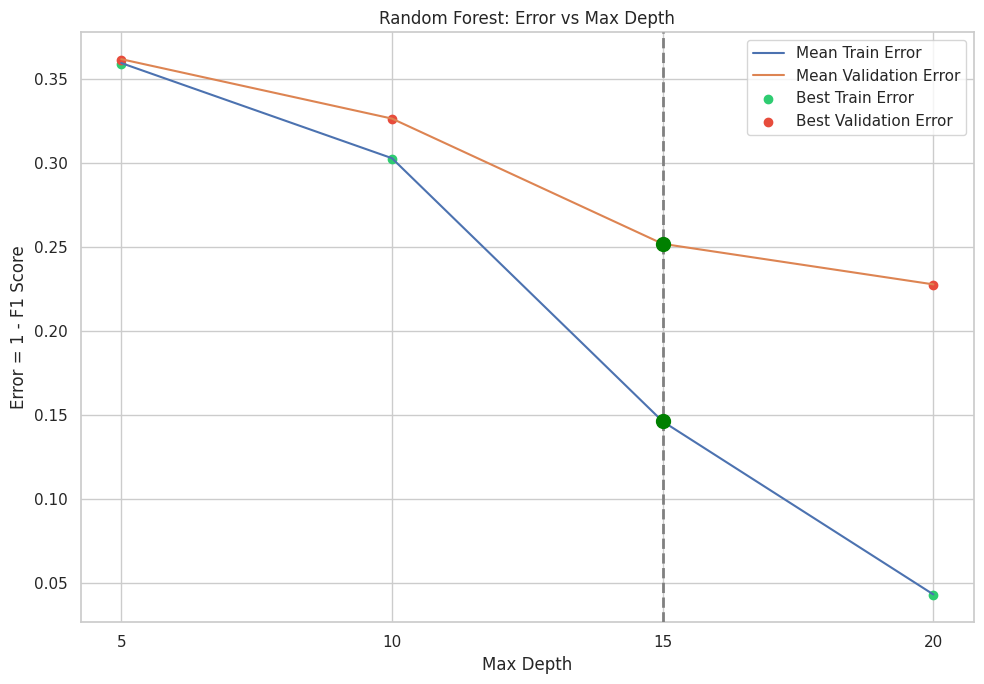

In [6]:
with open("../../models/tuning/random_forest_tuning.json") as f:
    data = json.load(f)
filtered = []
for entry in data['all_combinations']:
    try:
        max_depth = float(entry['params']['max_depth'])
        mean_train_score = float(entry['mean_train_score'])
        mean_test_score = float(entry['mean_test_score'])
        filtered.append({
            'max_depth': max_depth,
            'train': 1 - mean_train_score,
            'val': 1 - mean_test_score,
        })
    except (ValueError, TypeError):
        continue

df = pd.DataFrame(filtered)

res = df.groupby("max_depth").agg(
    mean_train=('train', 'mean'),
    mean_val=('val', 'mean'),
    best_train=('train', 'min'),
    best_val=('val', 'min'),
).reset_index()

plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")
plt.plot(res["max_depth"], res["mean_train"], label="Mean Train Error")
plt.plot(res["max_depth"], res["mean_val"], label="Mean Validation Error")
plt.scatter(res["max_depth"], res["best_train"], color="#2ecc71", label="Best Train Error")
plt.scatter(res["max_depth"], res["best_val"], color="#e74c3c", label="Best Validation Error")
k = 15
y_train = res.loc[res["max_depth"] == k, "mean_train"].values
y_val = res.loc[res["max_depth"] == k, "mean_val"].values
if len(y_train) > 0:
    plt.scatter(k, y_train[0], color='green', s=100, zorder=10)
if len(y_val) > 0:
    plt.scatter(k, y_val[0], color='green', s=100, zorder=10)
plt.axvline(x=k, color='grey', linestyle='--', linewidth=2, zorder=5)
plt.xlabel("Max Depth")
plt.ylabel("Error = 1 - F1 Score")
plt.title("Random Forest: Error vs Max Depth")
plt.xticks(sorted(df['max_depth'].unique()))
plt.legend()
plt.tight_layout()
plt.show()

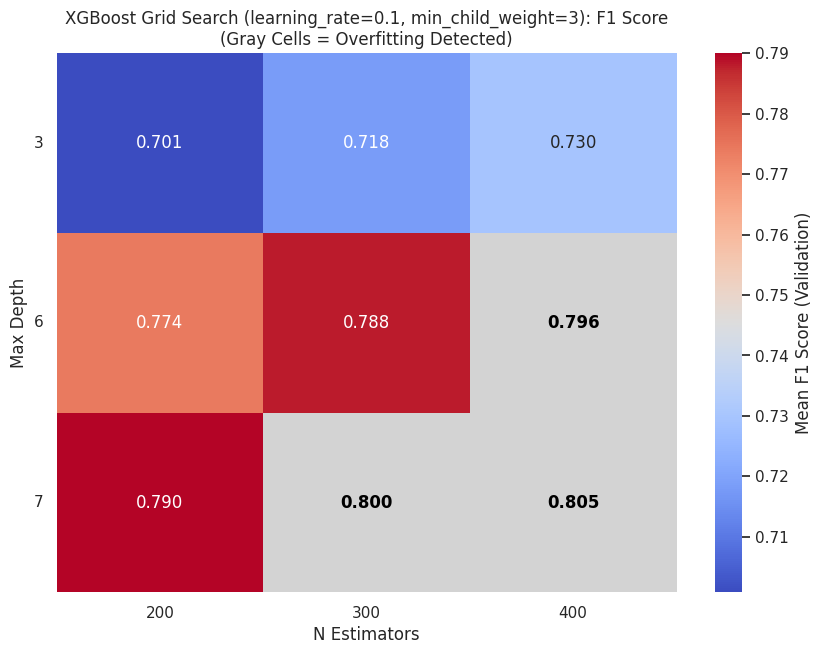

In [4]:
with open("../../models/tuning/xgboost_tuning.json", "r") as f:
    data = json.load(f)

rows = []
max_depths = set()
n_estimators = set()
scores_nonoverfit = []
scores_overfit = []
for entry in data['all_combinations']:
    p = entry['params']
    if p.get('learning_rate', None) != 0.1:
        continue
    if p.get('min_child_weight', None) != 3:
        continue
    md = p['max_depth']
    ne = p['n_estimators']
    max_depths.add(md)
    n_estimators.add(ne)
    rows.append({
        'n_estimators': ne,
        'max_depth': md,
        'F1 Score': entry['mean_test_score'],
        'Overfitting': entry['is_overfitting']
    })
    if not entry['is_overfitting']:
        scores_nonoverfit.append(entry['mean_test_score'])
    else:
        scores_overfit.append(entry['mean_test_score'])

df = pd.DataFrame(rows)

sorted_md = sorted(max_depths)
sorted_ne = sorted(n_estimators)

group_cols = ["max_depth", "n_estimators"]
df_nodup = df.sort_values("F1 Score", ascending=False).drop_duplicates(subset=group_cols, keep="first")

pivot_f1 = df_nodup.pivot(index='max_depth', columns='n_estimators', values='F1 Score')
pivot_overfit = df_nodup.pivot(index='max_depth', columns='n_estimators', values='Overfitting')

pivot_f1 = pivot_f1.reindex(index=sorted_md, columns=sorted_ne)
pivot_overfit = pivot_overfit.reindex(index=sorted_md, columns=sorted_ne)

plt.figure(figsize=(10, 7))
sns.set_theme(style="white")

sns.heatmap(
    pivot_f1, 
    mask=~pivot_overfit.astype(bool),
    cmap=mcolors.ListedColormap(['#d3d3d3']),
    annot=True,
    fmt=".3f",
    cbar=False,
    annot_kws={'color': 'black', 'weight': 'bold'}
)

ax = sns.heatmap(
    pivot_f1, 
    mask=pivot_overfit.astype(bool),
    cmap="coolwarm",
    annot=True, 
    fmt=".3f",
    cbar_kws={'label': 'Mean F1 Score (Validation)'}
)

plt.title('XGBoost Grid Search (learning_rate=0.1, min_child_weight=3): F1 Score\n(Gray Cells = Overfitting Detected)')
plt.ylabel('Max Depth')
plt.xlabel('N Estimators')
plt.yticks(rotation=0)

plt.show()